In [1]:
import random
import tensorflow as tf
import numpy as np

tf.keras.utils.set_random_seed(17)  # sets seeds for base-python, numpy and tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# PREPROCESSING

In [2]:
import pandas as pd
df = pd.read_csv("data/tweets.csv")

In [3]:
df.head()

,Text,Cleaned_Text,English_Only_Cleaned_Text,vader,compound,Vader_Sentiment_Type
0,@R_H_D__ @DanielTheHuman1 @StrewthQueen @Willi...,it really is not but good to know you wil...,it really is not but good to know you will bel...,"{'neg': 0.119, 'neu': 0.809, 'pos': 0.072, 'co...",-0.3516,NEGATIVE
1,@idsharman Indeed. I'll let us take a teensy f...,indeed i will let us take a teensy fraction ...,indeed i will let us take a teensy fraction of...,"{'neg': 0.0, 'neu': 0.844, 'pos': 0.156, 'comp...",0.7269,POSITIVE
2,@klucy239 @Mc3Mc336241251 @GOP actually its no...,actually its not not only have child drag ...,actually its not not only have child drag been...,"{'neg': 0.063, 'neu': 0.937, 'pos': 0.0, 'comp...",-0.2684,NEGATIVE
3,#SINGAPORE: Government considering repeal of s...,government considering repeal of sodomy law ...,government considering repeal of sodomy law al...,"{'neg': 0.136, 'neu': 0.606, 'pos': 0.258, 'co...",0.2960,POSITIVE
4,"""On A Clear Day You Can See Forever"" #musical ...",on a clear day you can see forever opening ni...,on a clear day you can see forever opening nig...,"{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...",0.9349,POSITIVE


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Text                       20000 non-null  object 
 1   Cleaned_Text               20000 non-null  object 
 2   English_Only_Cleaned_Text  19835 non-null  object 
 3   vader                      20000 non-null  object 
 4   compound                   20000 non-null  float64
 5   Vader_Sentiment_Type       20000 non-null  object 
dtypes: float64(1), object(5)
memory usage: 937.6+ KB


In [5]:
df[df.duplicated()]

,Text,Cleaned_Text,English_Only_Cleaned_Text,vader,compound,Vader_Sentiment_Type
136,@sliverbackapes @Badabook123 @Neeldesi @TeaSpi...,ok racist,racist,"{'neg': 0.645, 'neu': 0.0, 'pos': 0.355, 'comp...",-0.4215,NEGATIVE
1115,@hannahsbee #Thankyou from MBE [LGBT],from mbe [lgbt],from [ ],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
1116,@hannahsbee #Thankyou from MBE [LGBT],from mbe [lgbt],from [ ],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
1117,@hannahsbee #Thankyou from MBE [LGBT],from mbe [lgbt],from [ ],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
1118,@hannahsbee #Thankyou from MBE [LGBT],from mbe [lgbt],from [ ],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
...,...,...,...,...,...,...
19628,"An insane thought of becoming vigilantes, coup...",an insane thought of becoming vigilantes coup...,an insane thought of becoming coupled with the...,"{'neg': 0.169, 'neu': 0.831, 'pos': 0.0, 'comp...",-0.7269,NEGATIVE
19653,Just went live! https://t.co/5zHsS1gU8S\n\n#LG...,just went live,just went live,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
19824,hampton the hamster has done more for lgbt rig...,hampton the hamster has done more for lgbt rig...,the hamster done more for than anyone else,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,NEUTRAL
19921,lgbt community just fucking pissed me off,lgbt community just fucking pissed me off,community just me off,"{'neg': 0.428, 'neu': 0.572, 'pos': 0.0, 'comp...",-0.6697,NEGATIVE


In [6]:
df.rename(columns={"Vader_Sentiment_Type":"sentiment","Text":"text"}, inplace=True)
df = df[['text','sentiment']]

In [7]:
import re
import string
import emoji

##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [8]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [9]:
df['text_clean'] = texts_new

In [10]:
df['text_clean'].head()

0    it really isnt but good to know youll believe ...
1    indeed ill let us take a teensy fraction of re...
2    actually its not not only have child drag show...
3    singapore government considering repeal of sod...
4    on a clear day you can see forever musical ope...
Name: text_clean, dtype: object

In [11]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [12]:
df['text_len'] = text_len

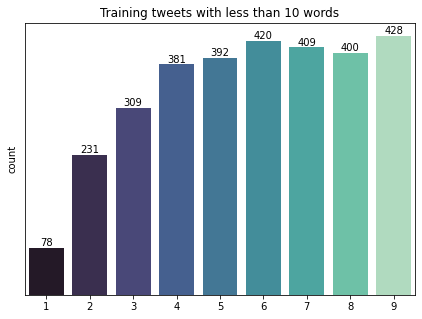

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [14]:
df.shape

(20000, 4)

In [15]:
df = df[df['text_len'] > 1]

In [16]:
df.shape

(19922, 4)

In [17]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [18]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [19]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 93


In [20]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 4938, TEXT: vc nem faz parte da comunidade lgbt garota acha que pode ficar fazendo piada ainda usa smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt smt
INDEX: 14365, TEXT: d russian dont hav n ther country 2 ruin my 200m career lifestyle wil paul whelan hav 2 win n a wizard witchs sorcery lgbt homosexual taliban ceos stack deck bwiths game wen he gets out of a rusian prison d nazis amp ther nigaz if u aint wt amp hav a nuk u beter keep it


In [21]:
df['token_lens'] = token_lens

In [22]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,text,sentiment,text_clean,text_len,token_lens
4958,@isadazx @MariaJose27942 @04h37m vc nem faz pa...,NEUTRAL,vc nem faz parte da comunidade lgbt garota ach...,46,93
14392,D Russian dont hav n ther Country 2 Ruin My 20...,NEGATIVE,d russian dont hav n ther country 2 ruin my 20...,57,81
6132,"@erasmus70 Fashion, fashion apapun atau mau be...",POSITIVE,fashion fashion apapun atau mau berekspresi se...,49,78
15486,CEOs Didn 💬 Abou Prisoner Swap 4 U n 3yrs as a...,NEGATIVE,ceos didn abou prisoner swap 4 u n 3yrs as a m...,52,77
15826,GA 🗳 #BlueCrew 💥👥🗳💥 #VoteBlue\n 🗣 #OurBlueVoic...,NEGATIVE,ga bluecrew voteblue ourbluevoice demvoice1 pl...,24,77
4723,also ill have a carrd at some point … idk … bu...,NEGATIVE,also ill have a carrd at some point idk but fo...,57,77
14125,Do any person n USA 💬 Paul Whelan &amp; Britan...,NEGATIVE,do any person n usa paul whelan amp britany gr...,59,76
8126,@mikatsuobushi andami kasing misconceptions do...,POSITIVE,andami kasing misconceptions don lalo na sa us...,54,76
8004,whatttt??? bruhh it’s just a fashion?? they ju...,NEUTRAL,whatttt bruhh its just a fashion they just exp...,40,75
320,Comfortable in my skin #Cozy\n✨ 🦄 🤸‍♀️ \n\n#fi...,POSITIVE,comfortable in my skin cozy fitness workout th...,24,74


In [23]:
df = df.iloc[8:]
df.head()

,text,sentiment,text_clean,text_len,token_lens
8004,whatttt??? bruhh it’s just a fashion?? they ju...,NEUTRAL,whatttt bruhh its just a fashion they just exp...,40,75
320,Comfortable in my skin #Cozy\n✨ 🦄 🤸‍♀️ \n\n#fi...,POSITIVE,comfortable in my skin cozy fitness workout th...,24,74
9583,@Clyyyde06 Oo that's true. Have you seen the v...,POSITIVE,oo thats true have you seen the video shared o...,58,73
10183,3. LGBT is cool. Should be taken more seriousl...,NEGATIVE,3 lgbt is cool should be taken more seriously ...,46,73
19793,#joinus #tonight on #twitch for ep 3 of the To...,NEUTRAL,joinus tonight on twitch for ep 3 of the tomb ...,30,73


In [24]:
df = df.sample(frac=1).reset_index(drop=True)

In [25]:
df['sentiment'] = df['sentiment'].map({'NEGATIVE':0,'NEUTRAL':1,'POSITIVE':2})

In [26]:
df['sentiment'].value_counts()

2    8844
0    7300
1    3770
Name: sentiment, dtype: int64

In [27]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
x, y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1))
df = pd.DataFrame(list(zip([i[0] for i in x], y)), columns = ['text', 'label'])

In [28]:
df['label'].value_counts()

2    8844
0    8844
1    8844
Name: label, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
#split the data into train and test set

temp,test = train_test_split(df, test_size=0.20, stratify=df['label'])
train,val = train_test_split(temp, test_size=0.25, stratify=temp['label'])

#save the data
train.to_csv('data/tweets_train.csv',index=False)
val.to_csv('data/tweets_val.csv',index=False)
test.to_csv('data/tweets_test.csv',index=False)

# SENTIMENT ANALYSIS

In [30]:
train = pd.read_csv('data/tweets_train.csv')
val = pd.read_csv('data/tweets_val.csv')
test = pd.read_csv('data/tweets_test.csv')

In [31]:
X_train = train['text'].values
y_train = train['label'].values
X_val = val['text'].values
y_val = val['label'].values
X_test = test['text'].values
y_test = test['label'].values

In [32]:
y_train_le = y_train.copy()
y_val_le = y_val.copy()
y_test_le = y_test.copy()

In [33]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [34]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_val.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 15918
VALIDATION DATA: 5307
TESTING DATA: 5307


## BASELINE MODEL: NAIVE BAYES CLASSIFIER

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [36]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [37]:
nb_clf = MultinomialNB()

In [38]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [39]:
nb_pred = nb_clf.predict(X_test_tf)

In [40]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.60      0.88      0.71      1769
     Neutral       0.92      0.63      0.75      1769
    Positive       0.74      0.63      0.68      1769

    accuracy                           0.71      5307
   macro avg       0.75      0.71      0.71      5307
weighted avg       0.75      0.71      0.71      5307



# BERT MODEL

In [41]:
MAX_LEN = 80

In [42]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [43]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [44]:
from transformers import TFBertModel

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [45]:
def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [46]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 80,                                            

In [54]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=5, batch_size=4)

Epoch 1/5
3980/3980 [==============================] - 1101s 277ms/step - loss: 0.5146 - categorical_accuracy: 0.8000 - val_loss: 0.3826 - val_categorical_accuracy: 0.8592
Epoch 2/5
3980/3980 [==============================] - 1088s 273ms/step - loss: 0.2861 - categorical_accuracy: 0.9014 - val_loss: 0.3256 - val_categorical_accuracy: 0.8851
Epoch 3/5
3980/3980 [==============================] - 1114s 280ms/step - loss: 0.1465 - categorical_accuracy: 0.9522 - val_loss: 0.3705 - val_categorical_accuracy: 0.8839
Epoch 4/5
3980/3980 [==============================] - 1138s 286ms/step - loss: 0.0832 - categorical_accuracy: 0.9736 - val_loss: 0.4530 - val_categorical_accuracy: 0.8879
Epoch 5/5
3980/3980 [==============================] - 1121s 282ms/step - loss: 0.0498 - categorical_accuracy: 0.9844 - val_loss: 0.4915 - val_categorical_accuracy: 0.8826


In [71]:
history_bert.history

{'loss': [0.5145924091339111,
  0.28608039021492004,
  0.146495059132576,
  0.0831947922706604,
  0.049781471490859985],
 'categorical_accuracy': [0.7999748587608337,
  0.9013695120811462,
  0.952192485332489,
  0.9736147522926331,
  0.9844201803207397],
 'val_loss': [0.382569819688797,
  0.32560259103775024,
  0.3705049753189087,
  0.45299604535102844,
  0.49148133397102356],
 'val_categorical_accuracy': [0.8592424988746643,
  0.8850574493408203,
  0.8839268684387207,
  0.8878839015960693,
  0.8826078772544861]}

c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


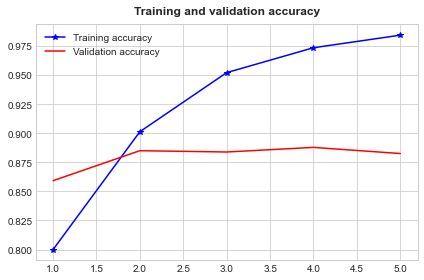

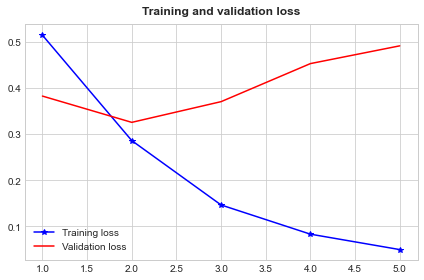

In [72]:
# plot the results

train_acc = history_bert.history['categorical_accuracy']
val_acc = history_bert.history['val_categorical_accuracy']
train_loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'b*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure() # Creates two independent plots

plt.plot(epochs, train_loss, 'b*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [55]:
result_bert = model.predict([test_input_ids,test_attention_masks])

166/166 [==============================] - 67s 375ms/step


In [56]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [59]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.84      0.89      0.87      1769
     Neutral       0.91      0.95      0.93      1769
    Positive       0.89      0.79      0.84      1769

   micro avg       0.88      0.88      0.88      5307
   macro avg       0.88      0.88      0.88      5307
weighted avg       0.88      0.88      0.88      5307
 samples avg       0.88      0.88      0.88      5307



In [73]:
#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

C:\Users\user\AppData\Local\Temp\ipykernel_58012\1787276967.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 432x288 with 0 Axes>

c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


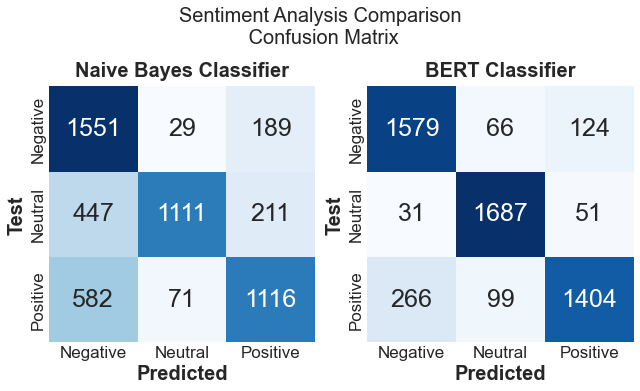

In [69]:

fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),nb_pred), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('Naive Bayes Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17)
ax[0].set_xticklabels(labels, fontsize=17)
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('BERT Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17)
ax[1].set_xticklabels(labels, fontsize=17)
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()